

> Import Packages



---



In [104]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Convolution2D,Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras import optimizers
import os, shutil
from os import listdir
import cv2
from tqdm import tqdm
import random

> Segregate the images into folders based on labels
---

Folder Name
*   Abdomen
*   Chest
*   Head

Ref: https://stackoverflow.com/questions/52752860/copy-paste-image-dataset-from-single-folder-to-subfolders-based-on-their-filehttps://stackoverflow.com/questions/52752860/copy-paste-image-dataset-from-single-folder-to-subfolders-based-on-their-file













In [105]:
def create_subdirectory():
    mypath = "/content/drive/My Drive/Smart Health/Assignment_3/DS/"
    count=1
    for files in listdir(mypath):
        #print(count)
        count=count+1
        directory = (files.split('_'))[0]
        if not os.path.exists(directory):
            #create directory
            os.makedirs(directory)
            print("Created "+directory)
            #copy image to the directory
            shutil.copy("/content/drive/My Drive/Smart Health/Assignment_3/DS/" + files, (directory))
        else:
            shutil.copy("/content/drive/My Drive/Smart Health/Assignment_3/DS/" + files, (directory))\

create_subdirectory()

Verify the count in each Folder

In [106]:
print(len(listdir("/content/Head/")))
print(len(listdir("/content/Chest/")))
print(len(listdir("/content/Abdomen/")))

500
500
500


See the current dimension of an image

In [107]:
image = cv2.imread("/content/Abdomen/Abdomen_CT Sample#0.jpeg")
image.shape

(64, 64, 3)

> Image Preprocessing


---
The function below iterate through each image and performs the below step for each image

1.   Read the image 
2.   Grayscale it
3.   Resize it
4.   Append it to the global array training_data in the format [img,label]


In [108]:
IMG_SIZE=32
root_dir = "/content"
target_labels = ["Abdomen", "Chest","Head"]
training_data = []
def create_training_data():
    for category in target_labels:  
        path = os.path.join(root_dir,category)
        # get the classification labels. 0=Abdomen 1=Chest 2=Head
        class_num = target_labels.index(category)  
        # iterate over each image 
        for img in tqdm(os.listdir(path)):  
            try:
                # convert to array
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                # resize image size
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                # add this to our training_dat
                training_data.append([new_array, class_num])
            except Exception as e: 
                print(e)

create_training_data()

100%|██████████| 500/500 [00:00<00:00, 12844.53it/s]


Verify the lenght of training_data and examine the data

In [109]:
print("Number of entries in training_data: ",end="")
print(len(training_data))
print("Entry at index 0 in Training Data\n")
print(training_data[0])
print("\nIt contains an image in 32*32 format and the associated label")
print("\nResized Image Size",end="")
print(training_data[0][0].shape)

Number of entries in training_data: 1500
Entry at index 0 in Training Data

[array([[101, 101, 101, ..., 101, 101, 101],
       [101, 101, 101, ..., 101, 101, 101],
       [101, 101, 101, ..., 101, 101, 101],
       ...,
       [101, 101, 101, ..., 101, 101, 101],
       [101, 101, 101, ..., 101, 101, 101],
       [101, 101, 101, ..., 101, 101, 101]], dtype=uint8), 0]

It contains an image in 32*32 format and the associated label

Resized Image Size(32, 32)


Shuffle the training_data

In [110]:
random.shuffle(training_data)

Segreate the images (array) and label into X and Y

In [111]:
X = []
Y = []
for features,label in training_data:
    X.append(features)
    Y.append(label)


Both X and Y are list and needs to be converted to numpy array

In [112]:
print(len(X))
print(len(Y))

1500
1500


Convert X in to numpy array and reshape it 

Post reshape X can be imagined as a table with
1500 (total images) rows. Each row having 32*32 array

Reshape parameters

*  -1 : Indicated that the table can have dynamic number of rows
*   IMG_Size,IMG_Size : Indicates the size of data inside each row
*   1 : Even thought we are building Conv2D model the data that is passed to the model must be 3D




  




In [113]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(X.shape)

(1500, 32, 32, 1)


Y represent classification labels. The datatype of Y is list would be converted to categorical array, later in the script

In [114]:
type(Y)

list


Normalize the image

In [115]:
#Each  image array has value in the range of 0-255 so we normalize it by dividing it by 255
X = X.astype('float32')/255.0
#Verifying the denomination
print(X[0][0][:10])

[[0.09803922]
 [0.09803922]
 [0.09803922]
 [0.09803922]
 [0.09803922]
 [0.09803922]
 [0.09803922]
 [0.09803922]
 [0.09803922]
 [0.09803922]]




> Split the Train and Test Model

---





In [116]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.20)

In [117]:
print("xTrain and yTrain length: ",end="")
print(len(xTrain),len(yTrain))
print("xTest and yTest length: ",end="")
print(len(xTest),len(yTest))

xTrain and yTrain length: 1200 1200
xTest and yTest length: 300 300


Convertion of yTrain to categorical

In [118]:
print("xTrain Shape ",end="")
print(xTrain.shape)
new_yTrain = to_categorical(yTrain,3)
print("yTrain Shape ",end="")
print(new_yTrain.shape)

xTrain Shape (1200, 32, 32, 1)
yTrain Shape (1200, 3)




> Function to calculate the Performance Metrics

---





In [119]:
def showResults(modelname,test, pred):
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("Confusion Matrix")
    cm=confusion_matrix(test, pred)
    print(cm)
    results=[(modelname,"Accuracy",accuracy),(modelname,"Precision",precision),(modelname,"F1Score",f1Score)]
    return results



> CNN Model Defination

---






In [120]:
verbose, epoch, batch_size = 1, 20, 32
activationFunction='relu'

def getModel():
    cnnmodel = Sequential()
    
    cnnmodel.add(Conv2D(50, kernel_size = (5, 5), activation=activationFunction, 
                input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    cnnmodel.add(Dropout(0.1))
    cnnmodel.add(MaxPooling2D(pool_size=(2,2)))
    
    cnnmodel.add(Flatten())
    cnnmodel.add(Dropout(0.1))
    cnnmodel.add(Dense(30, activation=activationFunction))
    cnnmodel.add(Dropout(0.1))
    cnnmodel.add(Dense(15, activation=activationFunction))
    cnnmodel.add(Dropout(0.1))
    cnnmodel.add(Dense(3, activation = 'softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy', 
                     metrics=['categorical_accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 50)        1300      
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 50)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9800)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9800)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                294030    
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)               

Train the CNN Model 

In [121]:
checkpoint = ModelCheckpoint("cnnmodel.h5",  # model filename
                             monitor='loss',
                             verbose=1, # verbosity - 0 or 1
                             save_best_only= True, 
                             mode='auto') 
early_stopping = EarlyStopping(monitor='loss',
                               patience=5,
                               verbose=1,
                               mode='auto')
# fit model
cnnhistory=cnnmodel.fit(xTrain,new_yTrain,
                        epochs=epoch,
                        validation_split=0.2,
                        batch_size=batch_size,callbacks=[checkpoint, early_stopping])

Epoch 1/20
29/30 [============================>.] - ETA: 0s - loss: 0.8663 - categorical_accuracy: 0.6207
Epoch 00001: loss improved from inf to 0.85725, saving model to cnnmodel.h5
30/30 [==============================] - 2s 59ms/step - loss: 0.8572 - categorical_accuracy: 0.6250 - val_loss: 0.4823 - val_categorical_accuracy: 0.9750
Epoch 2/20
29/30 [============================>.] - ETA: 0s - loss: 0.4713 - categorical_accuracy: 0.8384
Epoch 00002: loss improved from 0.85725 to 0.46787, saving model to cnnmodel.h5
30/30 [==============================] - 1s 48ms/step - loss: 0.4679 - categorical_accuracy: 0.8406 - val_loss: 0.2845 - val_categorical_accuracy: 0.9750
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.3017 - categorical_accuracy: 0.8792
Epoch 00003: loss improved from 0.46787 to 0.30167, saving model to cnnmodel.h5
30/30 [==============================] - 1s 47ms/step - loss: 0.3017 - categorical_accuracy: 0.8792 - val_loss: 0.1017 - val_categorical_a



> Feature Extraction from CNN

---





Pick the Fully-Connected layer just above the softmax

In [122]:
#Pick the Fully-Connected layer just above the softmax (-3 since their also a dropout layer)
print(cnnmodel.layers[-3].name)
layer_name = cnnmodel.layers[-3].name
feature_layer = Model(inputs=cnnmodel.input,outputs=cnnmodel.get_layer(layer_name).output)

dense_7


Extract the features for the Training images from the CNN feature layer. This 
training features would later be passed as input to the Random Forest model and KNN model



In [123]:
train_data_features=feature_layer.predict(xTrain,verbose=1)
print(train_data_features.shape)

38/38 [==============================] - 0s 8ms/step
(1200, 15)


In [124]:
train_features=pd.DataFrame(data=train_data_features)
train_features.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,13.705894,12.318461,5.829234,0.000000,0.000000,15.975816,0.0,0.000000,18.434242,0.0,13.687398,0.000000,0.000000,0.000000,22.127472
1,12.170424,11.140219,4.671603,0.000000,0.000000,14.019700,0.0,0.000000,15.989790,0.0,12.548737,0.000000,0.000000,0.000000,20.087120
2,0.000000,0.000000,0.618829,0.013024,0.279695,0.000000,0.0,3.989811,0.000000,0.0,3.077196,0.000000,0.000000,2.745128,2.954012
3,0.000000,0.000000,2.469976,4.446086,0.000000,0.000000,0.0,0.167962,0.000000,0.0,0.000712,4.187174,2.520313,0.926233,0.000000
4,0.000000,0.000000,2.474013,4.454425,0.000000,0.000000,0.0,0.184807,0.000000,0.0,0.000000,4.181838,2.507711,0.932903,0.000000




> Train Base Random Forest Model

---





In [125]:
#Feed the extracted features with the labels to Base Random Forest
base_rf = RandomForestClassifier(n_estimators = 20, random_state = 42,max_depth=100, max_features="auto")
base_rf.fit(train_features, new_yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Extract the features for the Testing images from the CNN feature layer. This test features would later be passed as input to the Random Forest model and KNN model

In [126]:
test_data_features=feature_layer.predict(xTest,verbose=1)
print(test_data_features.shape)

10/10 [==============================] - 0s 8ms/step
(300, 15)


In [127]:
test_features=pd.DataFrame(data=test_data_features)
test_features.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,11.572601,9.436187,5.005275,0.000000,0.0,12.776829,0.0,0.000000,15.111971,0.0,9.868665,0.000000,0.000000,0.000000,16.622303
1,0.000000,0.000000,2.470119,4.444720,0.0,0.000000,0.0,0.150594,0.000000,0.0,0.001858,4.199831,2.537509,0.920910,0.000000
2,14.026102,12.097694,6.291148,0.000000,0.0,15.896018,0.0,0.000000,18.954037,0.0,13.550426,0.000000,0.000000,0.000000,21.953379
3,11.426409,9.563692,4.807910,0.000000,0.0,13.078573,0.0,0.000000,15.045640,0.0,10.697501,0.000000,0.000000,0.000000,17.230272
4,0.000000,0.000000,2.492197,4.493297,0.0,0.000000,0.0,0.274802,0.000000,0.0,0.000000,4.147699,2.437075,0.967316,0.000000




> Evaluate Base Random Forest Model

---




In [128]:
base_rf_predictions = base_rf.predict(test_features)
print(base_rf_predictions.shape)

(300, 3)


Convertion of yTest to categorical

In [129]:
new_yTest=to_categorical(yTest,3)
print("new_yTest shape ",end="")
print(new_yTest.shape)

new_yTest shape (300, 3)




> Show the Performance Metrics for Base Random Forest Model

---





In [130]:
base_rf_predict = np.argmax(base_rf_predictions, axis=1)
base_rf_actual = np.argmax(new_yTest, axis=1)
showResults("Base RF",base_rf_actual, base_rf_predict)

Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Confusion Matrix
[[102   0   0]
 [  0 104   0]
 [  0   0  94]]


[('Base RF', 'Accuracy', 1.0),
 ('Base RF', 'Precision', 1.0),
 ('Base RF', 'F1Score', 1.0)]

Validated the Base RF Model using CV and calculate the roc_auc score 

In [131]:
#Combining the training and testing data for cross validation 
tempX=train_features.append(test_features)
print(tempX.shape)
tempY=yTrain+yTest
tempY=to_categorical(tempY,3)
print(tempY.shape)

(1500, 15)
(1500, 3)


In [132]:
#Here inbuild library cross_val_score is used to do cross validation of base RF model. 
#It gives better idea of the performance of the model since the model is tested against k groups of unseen test data
#Since esitmator (model) is a claissifier and ‘tempY’(target variable) is multicalss
#cross_val_score library will by default use Statifiedkfold cross validation
base_rf_cv_score = cross_val_score(base_rf, tempX, tempY, cv=10, scoring="roc_auc")

In [133]:
print("All AUC Scores")
print(base_rf_cv_score)
print("Mean AUC Score - Random Forest: ", base_rf_cv_score.mean())

All AUC Scores
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean AUC Score - Random Forest:  1.0




> HyperParameter optimization usign Random search Cross Validation


---

Ref:


*   https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
*   https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/



In [134]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]# number of features at every split
max_features = ["auto", "sqrt"]

# max depth
max_depth = [int(x) for x in np.linspace(20, 300, num = 10)]
max_depth.append(None)

# create random grid
random_grid = {
 "n_estimators": n_estimators,
 "max_features": max_features,
 "max_depth": max_depth}

# Random search of parameters
random_rf = RandomizedSearchCV(estimator = base_rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the model
random_rf.fit(train_features, new_yTrain)
# print results
print("Best Parameters are")
print(random_rf.best_params_)
print("Best Score is")
print(random_rf.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


Best Parameters are
{'n_estimators': 230, 'max_features': 'sqrt', 'max_depth': 206}
Best Score is
1.0


Evaluate the RandomSearch CV best model

In [135]:
#Extracting the best model
best_random=random_rf.best_estimator_
random_rf_predictions = best_random.predict(test_features)
print(random_rf_predictions.shape)

(300, 3)




> Compare the performance metrics of Base RF Model and RandomSearchCV model

---





In [136]:
print("Base Random Forest Model\n")
showResults("Base RF",base_rf_actual, base_rf_predict)
#base_rf_cv_score = cross_val_score(base_rf, tempX, tempY, cv=10, scoring="roc_auc")

print("All AUC Scores")
print(base_rf_cv_score)
print("Mean AUC Score - Random Forest: ", base_rf_cv_score.mean())

print("\nRandomSearchCV Model\n")
random_rf_predict = np.argmax(random_rf_predictions, axis=1)
random_rf_actual = np.argmax(new_yTest, axis=1)
random_rf_results=showResults("RandomSearchCV RF",random_rf_actual, random_rf_predict)
random_rf_cv_score = cross_val_score(best_random, tempX, tempY, cv=10, scoring="roc_auc")

print("All AUC Scores")
print(random_rf_cv_score)
print("Mean AUC Score - Random Forest: ", random_rf_cv_score.mean())

Base Random Forest Model

Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Confusion Matrix
[[102   0   0]
 [  0 104   0]
 [  0   0  94]]
All AUC Scores
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean AUC Score - Random Forest:  1.0

RandomSearchCV Model

Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Confusion Matrix
[[102   0   0]
 [  0 104   0]
 [  0   0  94]]
All AUC Scores
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean AUC Score - Random Forest:  1.0


Train Base KNN Model

In [137]:
# Create KNN classifier
base_knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
base_knn.fit(train_features, new_yTrain)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [138]:
base_knn_predictions=base_knn.predict(test_features)
print(base_knn_predictions.shape)

(300, 3)


Show Performance Metrics for Base KNN Model

In [139]:
base_knn_predict = np.argmax(base_knn_predictions, axis=1)
base_knn_actual = np.argmax(new_yTest, axis=1)
showResults("Base KNN",base_knn_actual, base_knn_predict)

Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Confusion Matrix
[[102   0   0]
 [  0 104   0]
 [  0   0  94]]


[('Base KNN', 'Accuracy', 1.0),
 ('Base KNN', 'Precision', 1.0),
 ('Base KNN', 'F1Score', 1.0)]

Validated the Base KNN Model using CV and calculate the roc_auc score 

In [140]:
#Here inbuild library cross_val_score is used to do cross validation of base KNN model. Since esitmator (model) is a claissifier and ‘tempY’(target variable) is multicalss
#cross_val_score library will by default use Statifiedkfold cross validation
base_knn_cv_score = cross_val_score(base_knn, tempX, tempY, cv=10, scoring="roc_auc")

In [141]:
print("All AUC Scores")
print(base_knn_cv_score)
print("Mean AUC Score - Random Forest: ", base_knn_cv_score.mean())

All AUC Scores
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean AUC Score - Random Forest:  1.0


> HyperParameter optimization usign Grid Search Cross Validation

---
Ref:
https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a


In [142]:
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": [3,5,7,9]}
#use gridsearch to test all values for n_neighbors
grid_knn = GridSearchCV(base_knn, param_grid, cv=3)
#fit model to data
grid_knn.fit(train_features, new_yTrain)
print("Best Parameters are")
print(grid_knn.best_params_)
print("Best Score is")
print(grid_knn.best_score_)

Best Parameters are
{'n_neighbors': 3}
Best Score is
1.0


In [143]:
grid_knn_scores_df = pd.DataFrame(grid_knn.cv_results_['params'])
grid_knn_scores_df['test_score'] = grid_knn.cv_results_['mean_test_score']

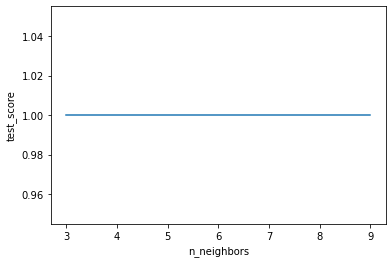

In [144]:
#grid_knn_scores_df.head(5)
ax = sns.lineplot(x="n_neighbors", y="test_score", data=grid_knn_scores_df)
figure=ax.get_figure()
#figure.savefig('/content/drive/My Drive/Smart Health/Assignment_3/K_Value_Graph', format='png', dpi=600)

In [145]:
best_grid=grid_knn.best_estimator_
grid_knn_predictions = best_grid.predict(test_features)
print(grid_knn_predictions.shape)

(300, 3)


In [146]:
print("Base KNN Model\n")
showResults("Base KNN",base_knn_actual, base_knn_predict)
#base_rf_cv_score = cross_val_score(base_nn, tempX, tempY, cv=10, scoring="roc_auc")
print("All AUC Scores")
print(base_knn_cv_score)
print("Mean AUC Score - KNN: ", base_knn_cv_score.mean())

print("\nGridSearchCV Model\n")
grid_knn_predict = np.argmax(grid_knn_predictions, axis=1)
grid_knn_actual = np.argmax(new_yTest, axis=1)
grid_knn_results=showResults("GridSearchCV KNN",grid_knn_actual, grid_knn_predict)
grid_knn_cv_score = cross_val_score(best_grid, tempX, tempY, cv=10, scoring="roc_auc")
print("All AUC Scores")
print(grid_knn_cv_score)
print("Mean AUC Score - KNN: ", grid_knn_cv_score.mean())

Base KNN Model

Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Confusion Matrix
[[102   0   0]
 [  0 104   0]
 [  0   0  94]]
All AUC Scores
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean AUC Score - KNN:  1.0

GridSearchCV Model

Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Confusion Matrix
[[102   0   0]
 [  0 104   0]
 [  0   0  94]]
All AUC Scores
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean AUC Score - KNN:  1.0


In [147]:
grid_knn_actual.shape

(300,)

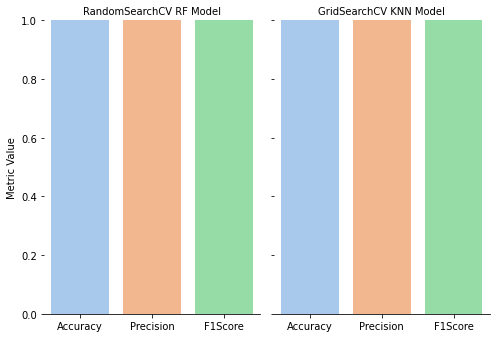

In [148]:
#print(random_rf_results)
#print(grid_knn_results)
#print(random_rf_results+grid_knn_results)

final_df=pd.DataFrame(random_rf_results+grid_knn_results,columns=["Model","Metric","Value"])
g = sns.catplot(x="Metric", y="Value", col="Model", palette="pastel",data=final_df, saturation=0.8,kind="bar", ci=None,aspect=.7)

(g.set_axis_labels("", "Metric Value")

  .set_xticklabels(["Accuracy", "Precision", "F1Score"])

  .set_titles("{col_name} {col_var}")

  .set(ylim=(0, 1))

  .despine(left=True))  

#figure1=g.getfigure()
#figure1.savefig('/content/drive/My Drive/Smart Health/Assignment_3/RFC VS KNN Plot', format='png', dpi=600)

Save Model

In [149]:
pkl_filename1 = "/content/drive/My Drive/Smart Health/Assignment_3/0892691-RF.pkl"
with open(pkl_filename1, 'wb') as file:
    pickle.dump(best_random, file)

In [150]:
pkl_filename2 = "/content/drive/My Drive/Smart Health/Assignment_3/0892691-KNN.pkl"
with open(pkl_filename2, 'wb') as file:
    pickle.dump(best_grid, file)